In [1]:
import series
from os import scandir
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
from matplotlib.dates import date2num
from matplotlib.colors import ListedColormap
from sys import stdout
import yaml
import sqlite3
import util

In [ ]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

cur.execute('SELECT DISTINCT Device, ObjectType, ObjectId, Property FROM PropertyValues')
features = cur.fetchall()

conn.close()

In [2]:
mappings = dict()
for file in scandir('../mappings'):
    if not file.name.endswith('.yaml'):
        continue
    with open(file, 'r') as fin:
        obj = yaml.safe_load(fin)
        mappings.update(util.update_names(obj))

In [ ]:
features_by_type = dict()
for elem in features:
    _, obj, _, prop = elem
    pres_flag = prop == 'presentValue'
    if prop in mappings[obj]:
        typ = mappings[obj][prop]['Type']
        if type(typ) == dict and typ['Name'] in ['list', 'array', 'object', 'object ref']:
            typ = typ['Name']
        elif typ not in ['number', 'bool', 'datetime', 'other']:
            print('Found type', mappings[obj][prop]['Type'])
            continue
        if pres_flag:
            typ = typ + '_pres'
        if typ not in features_by_type:
            features_by_type[typ] = []
        features_by_type[typ].append(elem)

In [20]:
def expand_series(timestamps, values):
    global start_date, end_date, date_range
    res = []
    timestamps = list(map(lambda t: datetime.datetime.strptime(t, TIME_FORMAT), timestamps))
    if timestamps[0] != start_date:
        timestamps = [start_date] + timestamps
        values = ['noFaultDetected'] + values
    for i in range(len(timestamps)):
        if timestamps[i].minute != 0:
            timestamps.pop(i)
            values.pop(i)
            break
    intervals = list(zip(timestamps, timestamps[1:] + [end_date]))
    
    for i, (int_start, int_end) in enumerate(intervals):
        # Align timestamp with 2-hour grid
        int_start = int_start.replace(second=0, microsecond=0)
        int_end = int_end.replace(second=0, microsecond=0)
        
        delta = int((int_end - int_start).total_seconds() / 3600)
        res += [values[i]] * delta
    
    return res

In [ ]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

bool_diagram = []
labels = []
time_ticks = set()

test_keys = [
    #('119503', 'device', 119503, 'daylightSavingsStatus')
    #('110201', 'device', 110201, 'activeCovSubscriptions'),
    #('116502', 'device', 116502, 'activeCovSubscriptions'),
    #('110209', 'device', 110209, 'activeCovSubscriptions')
]

for key in features_by_type['bool'][6:7]:
    if key in test_keys:
        continue
    res = series.fetch_series(key, cur)
    
    times, values = zip(*res)
    values = util.convert_bool(values)
    
    time_labels = []
    for elem in times:
        time = datetime.datetime.strptime(elem, TIME_FORMAT).replace(second=0, microsecond=0)
        start = start_date.replace(second=0, microsecond=0)
        tick = int((time - start).total_seconds() / 7200)
        time_labels.append((datetime.datetime.strftime(time, "%Y-%m-%d %Hh"), tick))
    time_ticks.update(time_labels)
    
    labels.append(f'{key[0]}:{key[1]}:{key[2]}:{key[3]}')
    exp = expand_series(times, values)
    bool_diagram.append(exp)

conn.close()

In [10]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

#items = [('binaryValue', 263), ('binaryValue', 264), ('binaryValue', 265), ('binaryValue', 266), ('binaryValue', 267)]#[('analogInput', 13), ('analogOutput', 6), ('multiStateOutput', 13), ('analogValue', 74)]
items = [(110629,), (110631,), (111502,), (111601,), (111602,), (111603,), (111604,), (111605,)]
data = []
for i in tqdm(range(len(items))):
    cur.execute('''SELECT Timestamp, Value FROM FullValues
                WHERE Device == ?
                AND ObjectType == 'device'
                --AND ObjectId == ?
                AND Property == 'daylightSavingsStatus'
                AND Timestamp BETWEEN '2024-10-22 00:00' AND '2024-11-01 00:00'
                ''', items[i])
    data.append(cur.fetchall())

conn.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:07<00:00,  8.46s/it]


In [11]:
data

[[('2024-10-26 16:00:02.028439', 'False')],
 [('2024-10-27 03:00:01.826692', 'False')],
 [('2024-10-27 04:00:01.731295', 'False')],
 [('2024-10-27 23:00:02.093356', 'False')],
 [('2024-10-27 03:00:01.826692', 'False')],
 [('2024-10-27 03:00:01.826692', 'False')],
 [('2024-10-27 03:00:01.826692', 'False')],
 [('2024-10-27 21:00:00.681833', 'False')]]

In [22]:
def shorten_time(str_time):
    dt_time = datetime.datetime.strptime(str_time, TIME_FORMAT)
    short_time = datetime.datetime.strftime(dt_time, TIME_FORMAT_SHORT)
    
    return short_time

TIME_FORMAT = "%Y-%m-%d %H:%M:%S.%f"
TIME_FORMAT_SHORT = "%Y-%m-%d %Hh"
start_date = datetime.datetime.strptime("2024-10-22 00:00:00.0", TIME_FORMAT)
end_date = datetime.datetime.strptime("2024-11-01 00:00:00.0", TIME_FORMAT)
date_range = [start_date + datetime.timedelta(hours=x)
                  for x in range(0, int((end_date - start_date).total_seconds() / 3600), 1)]
diagram = []
labels = []
for i in range(len(items)):
    times, values = zip(*data[i])
    print(len(expand_series(list(times), list(values))), len(date_range))
    diagram.append(util.enumerate_series(expand_series(list(times), list(values)), [False] * len(date_range)))

    #labels.append(f'Aggregator #5 {items[i][0]} #{items[i][1]}')
    labels.append(f'{items[i][0]}')
dt_cnt = len(date_range)
ticks_time = range(0, dt_cnt, dt_cnt // 10)#list(map(lambda x: datetime.datetime.strptime(x, TIME_FORMAT), times))
labels_time = list(map(lambda x: datetime.datetime.strftime(x, TIME_FORMAT_SHORT), date_range[::dt_cnt // 10]))

240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240


In [17]:
print([len(x) for x in diagram])

[121, 120, 121, 120, 120, 120, 120, 120]


In [ ]:
times, values = map(list, zip(*data[0]))
times = list(map(lambda x: datetime.datetime.strptime(x, TIME_FORMAT), times))
ticks_time = [start_date + datetime.timedelta(days=x) for x in range(7)]
labels_time = list(map(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'), ticks_time))
values = list(map(float, values))

plt.plot(times, values, linestyle='dashed', marker='x', linewidth=0.5, label='Analog Input #33')
plt.xticks(ticks_time, labels_time, rotation='vertical')
plt.yticks([300, 360000])
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

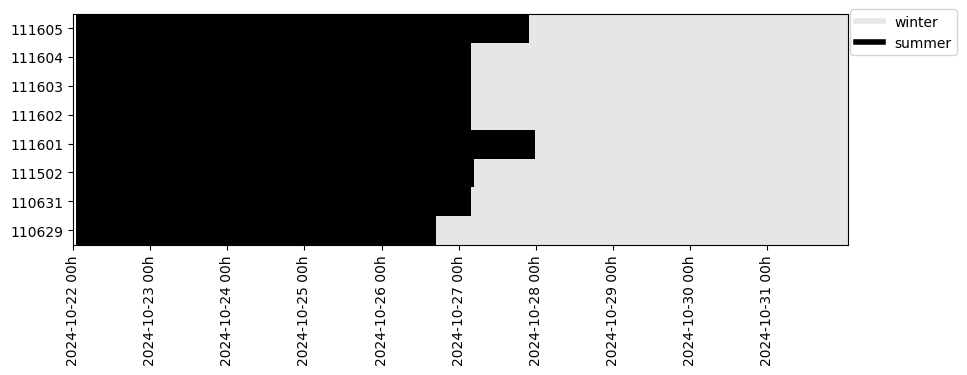

In [25]:
new_cmap = ListedColormap([
    [0.9, 0.9, 0.9, 1.0],  # false/off (white)
    [0.0, 0.0, 0.0, 1.0],  # invalid (red)
    [0.0, 0.0, 1.0, 1.0],  #   unused
    [0.5, 0.5, 0.5, 1.0],  # missing (gray)
    [0.0, 0.0, 0.0, 1.0],   # true/on (black) 
    [0.0, 0.0, 0.0, 1.0],   # true/on (black) 
    [0.0, 0.0, 0.0, 1.0],   # true/on (black) 
    [1.0, 1.0, 1.0, 1.0],   # true/on (black) 
])

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=new_cmap(0.), lw=4),
                Line2D([0], [0], color=new_cmap(.5), lw=4)]

#"""
plt.figure(figsize=(10, 3))
plt.pcolormesh(range(len(diagram[0]) + 1), range(len(labels) + 1), diagram, cmap=new_cmap)
#labels_time, ticks_time = zip(*sorted(time_ticks))
plt.xticks(ticks_time, labels_time, rotation='vertical')
plt.yticks([x + 0.5 for x in range(len(labels))], labels)
plt.legend(custom_lines, ['winter', 'summer'], bbox_to_anchor=(1.15, 1.05))
plt.show()
#"""

In [ ]:
for i, feat in enumerate(features_by_type['bool']):
    if i == 6:
        print(feat)
        break

In [ ]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

int_diagram = []
labels = []
time_ticks = set()

for key in features_by_type['number']:
    res = series.fetch_series(key, cur)
    
    if len(res) > 10:
        continue
    
    times = []
    values = []
    time_labels = []
    
    for elem in res:
        time = datetime.datetime.strptime(elem[0], TIME_FORMAT).replace(second=0, microsecond=0)
        #times.append(time)
        try:
            value = float(elem[1])
        except:
            value = 0
        values.append(value)
        
        start = start_date.replace(second=0, microsecond=0)
        tick = int((time - start).total_seconds() / 7200)
        times.append(tick)
        time_labels.append((datetime.datetime.strftime(time, "%Y-%m-%d %Hh"), tick))
    time_ticks.update(time_labels)
    
    int_diagram.append((times, values))
    labels.append(key)
    
    #print(time)
    #print(key, end='\n\t')
    #print(*res, sep='\n\t')

conn.close()

plt.figure(figsize=(20, 15))
for i in range(len(int_diagram)):
    plt.plot(int_diagram[i][0], int_diagram[i][1], marker='x', linestyle='dashed', label=labels[i])
labels_time, ticks_time = zip(*sorted(time_ticks))
plt.xticks(ticks_time, labels_time, rotation='vertical')
#plt.yticks([x + 0.5 for x in range(len(labels))], labels)
plt.legend()
plt.show()

In [ ]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

int_diagram = []
labels = []
time_ticks = set()

for key in features_by_type['number_pres']:
    res = series.fetch_series(key, cur)
    
    times = []
    values = []
    
    for elem in res:
        time = datetime.datetime.strptime(elem[0], TIME_FORMAT).replace(second=0, microsecond=0)
        try:
            value = float(elem[1])
        except:
            value = 0
        values.append(value)
        
        start = start_date.replace(second=0, microsecond=0)
        tick = int((time - start).total_seconds() / 7200)
        times.append(tick)
        time_labels.append((datetime.datetime.strftime(time, "%Y-%m-%d %Hh"), tick))
    time_ticks.update(time_labels)
    
    if len(set(values)) > 10:
        int_diagram.append((times, values))
        labels.append(key)
    
    #print(time)
    #print(key, end='\n\t')
    #print(*res, sep='\n\t')

conn.close()

plt.figure(figsize=(20, 15))
for i in range(len(int_diagram)):
    plt.plot(int_diagram[i][0], int_diagram[i][1], marker='x', linestyle='dashed', label=labels[i])
labels_time, ticks_time = zip(*sorted(time_ticks))
plt.xticks(ticks_time, labels_time, rotation='vertical')
#plt.yticks([x + 0.5 for x in range(len(labels))], labels)
plt.legend()
plt.show()

In [ ]:
set(map(lambda x: x[-1], features_by_type['list']))

In [ ]:
features_by_type.keys()

In [ ]:
series.load_fast(file='series.pickle')

In [ ]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

"""
items = []
names = ['analogInput', 'analogOutput', 'analogValue', 'binaryInput', 'binaryOutput', 'binaryValue']
for obj in tqdm(names):
    cur.execute("SELECT DISTINCT Device, ObjectType, ObjectId, Property FROM PropertyValues\
                 WHERE Property == 'presentValue' AND ObjectType == ?", (obj,))
    items.append(cur.fetchall())
"""
cur.execute("SELECT DISTINCT Device, ObjectType, ObjectId, Property FROM PropertyValues\
             WHERE Property == 'presentValue'")
items = cur.fetchall()

conn.close()

In [ ]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

counts = [[0] * 1342 for i in range(6)]
for i in range(6):
    #lens = []
    for item in items[i]:
        ser_len = len(series.fast_fetch_series(item, cur))
        #lens.append(ser_len)
        counts[i][ser_len] += 1

conn.close()

In [ ]:
fig = plt.figure(figsize=(30, 20))
axs = fig.subplots(3, 2)
for i in range(6):
    ax = axs[i % 3, i // 3]
    ax.bar(range(len(counts[i])), counts[i])
    ax.set_title(names[i])
    ax.set_yscale('log')
plt.yscale('log')
plt.show()

In [ ]:
TIME_FORMAT = "%Y-%m-%d %H:%M:%S.%f"
TIME_FORMAT_SHORT = "%Y-%m-%d %Hh"
start_date = datetime.datetime.strptime("2024-08-02 12:00:02.000213", TIME_FORMAT)
mid_date = datetime.datetime.strptime("2024-10-01 00:00:01.443302", TIME_FORMAT)
end_date = datetime.datetime.strptime("2024-11-01 00:00:02.276042", TIME_FORMAT)
DELAY = 3600
date_range = [(start_date + datetime.timedelta(hours=x)).replace(second=0, microsecond=0)
                  for x in range(0, int((mid_date - start_date).total_seconds() / 3600), 2)]
date_range += [(mid_date + datetime.timedelta(hours=x)).replace(second=0, microsecond=0)
                  for x in range(0, int((end_date - mid_date).total_seconds() / 3600), 1)]

In [ ]:
counts = []
ser_times = []

shorts = []
print('Starting', flush=True)
for feat in tqdm(items):
    ser = series.fast_fetch_series(feat, None)
    times = []
    last = None
    ser_short = []
    for time, value in ser:
        if time == '2024-08-22 18:46:01.017058':
             continue
        if len(times) == 0 or last != value:
            last = value
            times.append(time)
            ser_short.append((time, value))
    if len(times) >= 2 and len(times) < 10:
        shorts.append((feat, ser_short))
        ser_times.append(map(lambda x: datetime.datetime.strptime(x, TIME_FORMAT).replace(second=0, microsecond=0), times))

counts = dict()
for elem in date_range:
    counts[elem] = 0
for ser in tqdm(ser_times):
    for elem in ser:
        counts[elem] += 1

In [ ]:
#print(sorted(set(counts.values())))
len(shorts)

In [ ]:
conn = sqlite3.connect('diff_v2.sqlite3')
cur = conn.cursor()

cur.execute('DELETE FROM PresentValues WHERE 1=1')

for key, items in tqdm(shorts):
    for item in items:
        cur.execute('INSERT INTO PresentValues (Device, ObjectType, ObjectId, Timestamp, Value) VALUES (?, ?, ?, ?, ?)',
                   key[:-1] + item)
    conn.commit()

conn.close()

In [ ]:
plt.bar(range(len(date_range)), counts.values())
#plt.xticks(range(len(date_range)), date_range)
plt.yscale('log')
plt.show()

In [ ]:
ser_times

In [ ]:
mappings['device']['activeCovSubscriptions']

In [ ]:
def parse_date(name):
    dt = name[4:17]
    year = int(dt[:4])
    month = int(dt[4:6])
    day = int(dt[6:8])
    hour = int(dt[9:11])
    minute = int(dt[11:13])
    return datetime.datetime(year, month, day, hour, minute, 0)

In [ ]:
data = []

files = list(scandir('../data'))

for file in tqdm(files):
    if file.name.startswith('data20240502'):
        continue
    try:
        fin = open(file.path)
        item = file_parser.parse_old(fin)
        fin.close()
    except:
        fin.close()
        fin = open(file.path)
        item = file_parser.parse_new(fin)
        fin.close()
    data.append((parse_date(file.name), item))

In [ ]:
target = '192.168.66.16'#'192.168.67.198'
prop = 'presentValue'

info = dict()
values = dict()
for date, point in data:
    if target not in point:
        continue
    dev = point[target]
    
    for obj in dev:
        for prp in dev[obj]:
            val = dev[obj][prp]
            if prp == 'description' and len(val) > 0:
                info[obj] = val
            elif prp == 'units':
                info[obj] = 'measured in ' + val
        if prop in dev[obj]:
            if obj not in values:
                values[obj] = []
            values[obj].append((date, dev[obj][prop]))

In [ ]:
def transform_float(series):
    return list(map(lambda x: x[0], series)), list(map(lambda x: float(x[1]), series))

def transform(series):
    return list(map(lambda x: x[0], series)), list(map(lambda x: x[1], series))

picked = [
    'binaryValue:260',
    'binaryValue:263',
    'binaryValue:264',
    'binaryValue:265',
    'binaryValue:266',
    'binaryValue:267',
    'binaryValue:268',
    'binaryValue:269',
    'binaryValue:270',
    'binaryValue:271',
    'binaryValue:272',
    'binaryValue:273',
    'binaryValue:274',
    'binaryValue:300',
    'binaryValue:308',
    #'binaryValue:435',
]
values_prc = dict()
values_onoff = dict()
values_other = dict()
values_enum = dict()
values_unsigned = dict()
values_picked = dict()
for key in values:
    rng = set(map(lambda x: x[1], values[key]))
    if len(rng) <= 1:
        continue
    if key in picked:
        values_picked[key] = values[key]
    elif rng == set(['inactive', 'active']):
        values_onoff[key] = values[key]
    elif rng == set(['0.0', '100.0']):
        values_prc[key] = values[key]
    elif 'Enumerated(0)' in rng or 'Enumerated(1)' in rng:
        values_enum[key] = values[key]
    elif 'Unsigned(4)' in rng:
        values_unsigned[key] = values[key]
    else:
        values_other[key] = values[key]

In [ ]:
fig = plt.figure(figsize=(20, 10))
skip = [6, 7]
start = None #datetime.datetime(2024, 5, 9, 16, 0, 0)
end = datetime.datetime(2024, 5, 9, 20, 0, 0)
#skip = [2, 5, 6, 7, 12]
#skip += [11, 13, 18, 19]
for i, key in enumerate(values_other):
    if i >= 20:
        break
    if i not in skip:
        continue
    try:
        xs, ys = transform_float(values[key])
        plt.plot(xs, ys, label=key)
    except:
        print(values[key])
if start is not None:
    fig.axes[0].set_xlim(start, end)
fig.legend(loc='lower center')
plt.show()

In [ ]:
info

In [ ]:
values.keys()

In [ ]:
arr = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.125, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
arr2 = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

In [ ]:
arr[204:]

In [ ]:
diagram = [arr]#[[0, 0.125, 0.25, 0.25]]

In [ ]:
new_cmap = ListedColormap([
    [0.5, 0.5, 0.5, 1.0],   # Gray
    [0.0, 0.0, 0.0, 1.0],   # Black
    [0.0, 0.0, 1.0, 1.0],   # Blue
    [0.0, 1.0, 0.0, 1.0],   # Green
    [0.0, 1.0, 1.0, 1.0],   # Cyan
    [1.0, 0.0, 0.0, 1.0],   # Red
    [1.0, 0.0, 1.0, 1.0],   # Magenta
    [1.0, 1.0, 0.0, 1.0],   # Yellow
])

plt.pcolormesh(range(len(arr) + 1), range(2), diagram, cmap=new_cmap)
plt.show()